# Description:

* Simulating bacterial communities using all of the bacterial genomes available.


### Workflow:

* symlink all genomes
* index all genomes

# Setting variables

In [1]:
workDir = '/home/nick/notebook/SIPSim/dev/bac_genome1210/'
SIPSimExe = '/home/nick/notebook/SIPSim/SIPSim'
genomeDir = '/var/seq_data/ncbi_db/genome/Feb2015/'

# Init

In [2]:
import os,sys
import numpy as np
import pandas as pd
#from ggplot import *
import matplotlib.pyplot as plt

In [3]:
%load_ext rpy2.ipython
%matplotlib inline

In [4]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [5]:
if not os.path.isdir(workDir):
    os.mkdir(workDir)

In [6]:
genomeDir = os.path.join(workDir, 'genomes')
if not os.path.isdir(genomeDir):
    os.mkdir(genomeDir)

# Getting genomes from ncbi

* Updating list of genomes from ncbi

## Getting table of prokaryote genomes

In [178]:
# using 'prokaryote.txt' file from the NCBI genome ftp site
!cd $genomeDir; \
    wget ftp://ftp.ncbi.nih.gov/genomes/GENOME_REPORTS/prokaryotes.txt

--2015-02-26 14:51:50--  ftp://ftp.ncbi.nih.gov/genomes/GENOME_REPORTS/prokaryotes.txt
           => `prokaryotes.txt'
Resolving ftp.ncbi.nih.gov (ftp.ncbi.nih.gov)... 130.14.250.13, 2607:f220:41e:250::10
Connecting to ftp.ncbi.nih.gov (ftp.ncbi.nih.gov)|130.14.250.13|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /genomes/GENOME_REPORTS ... done.
==> SIZE prokaryotes.txt ... 7665180
==> PASV ... done.    ==> RETR prokaryotes.txt ... done.
Length: 7665180 (7.3M) (unauthoritative)

100%[======================================>] 7,665,180   16.6M/s   in 0.4s    

2015-02-26 14:51:51 (16.6 MB/s) - `prokaryotes.txt' saved [7665180]



In [179]:
! printf "Number of lines in old (delta-GC dataset) version of prokaryotes.txt: "
! cd $genomeDir; \
    wc -l archive/deltaGC_dataset/prokaryotes.txt | perl -pe 's/ .+//'
! printf "Number of lines in new version of prokaryotes.txt: "
! cd $genomeDir; \
    wc -l prokaryotes.txt | perl -pe 's/ .+//'

Number of lines in old (delta-GC dataset) version of prokaryotes.txt: 23504
Number of lines in new version of prokaryotes.txt: 31639


In [181]:
os.chdir(genomeDir)

# loading table
proks = pd.read_csv('prokaryotes.txt', sep='\t')
print "Number of rows in full table: {}".format(proks.shape[0])

# filtering table
## just closed genomes (1 scaffold per chromosome)
### *Complete* in 'Status' field
proks = proks.loc[proks['Status'].isin(['Complete','Complete Genome'])]
print "Number of rows with a complete genome entry: {}".format(proks.shape[0])

Number of rows in full table: 31638
Number of rows with a complete genome entry: 3612


### Filtering prokaryotes file

* Only using 'complete' genomes.
* Using the most recent version of each genome.
* Adding taxonomy for each entry.

In [188]:
!cd $genomeDir; \
    seqDB_tools NCBIprokaryoteTableFilter \
    -t 30 prokaryotes.txt \
    > prokaryotes_filt.txt 2> NCBIprokaryoteTableFilter.log

In [189]:
!printf "Number of rows in filtered prokaryote table: "
!cd $genomeDir; wc -l prokaryotes_filt.txt | perl -pe 's/ .+//'

Number of rows in filtered prokaryote table: 3320


In [190]:
!wc -l NCBIprokaryoteTableFilter.log
!cd $genomeDir; \
    head -n 50 NCBIprokaryoteTableFilter.log

47 NCBIprokaryoteTableFilter.log
Loading table...
Just keeping most recent entries for same organism...
Adding taxonomy to each entry...

------------- EXCEPTION: Bio::Root::Exception -------------
MSG: Can't query website: 500 Can't connect to eutils.ncbi.nlm.nih.gov:80 (Connection timed out)
STACK: Error::throw
STACK: Bio::Root::Root::throw /usr/local/share/perl/5.14.2/Bio/Root/Root.pm:449
STACK: Bio::DB::Taxonomy::entrez::_run_query /usr/local/share/perl/5.14.2/Bio/DB/Taxonomy/entrez.pm:658
STACK: Bio::DB::Taxonomy::entrez::get_taxon /usr/local/share/perl/5.14.2/Bio/DB/Taxonomy/entrez.pm:326
STACK: main::get_lineage /home/nick/dev/seqDB_tools/bin/NCBIprokaryoteTableFilter.pl:305
STACK: main::add_taxonomy /home/nick/dev/seqDB_tools/bin/NCBIprokaryoteTableFilter.pl:289
STACK: /home/nick/dev/seqDB_tools/bin/NCBIprokaryoteTableFilter.pl:176
-----------------------------------------------------------

------------- EXCEPTION: Bio::Root::Exception -------------
MSG: Can't query website: 5

### Manual filtering

* Rhizobium_etli_CFN_42
    * no genome
* Lactobacillus_gasseri_ADH
    * phage genome

In [194]:
!cd $genomeDir; \
    perl -ne 'print if /Rhizobium etli CFN |Lactobacillus gasseri ADH/' prokaryotes_filt.txt

Rhizobium etli CFN 42	347834	PRJNA13932	13932	Proteobacteria	Alphaproteobacteria	6.53023	61.0458	NC_007761.1	CP000133.1	NC_007763.1,NC_007765.1,NC_004041.2,NC_007766.1,NC_007762.1,NC_007764.1	CP000135.1,CP000137.1,U80928.5,CP000138.1,CP000134.1,CP000136.1	-	7	6235	6001	2006/02/01	2015/02/08	Complete Genome	Centro de Ciencias Genomicas, Universidad Nacional Autonoma de Mexico	SAMN02603106	GCA_000092045.1	REPR	Rhizobium_etli/GCF_000092045	16505379	Bacteria	Proteobacteria	Alphaproteobacteria	Rhizobiales	Rhizobiaceae	Rhizobium	Rhizobium etli
Lactobacillus gasseri ADH	1395514	PRJNA249087	249087	Firmicutes	Bacilli	0.038269	37.4	-	KF767351.1	-	-	-	-	54	54	2014/04/03	2014/05/27	Complete	NCBI	-	-	-	-	24682298	Bacteria	Firmicutes	Bacilli	Lactobacillales	Lactobacillaceae	Lactobacillus	Lactobacillus gasseri


In [195]:
!cd $genomeDir; \
    perl -ni -e 'print unless /Rhizobium etli CFN |Lactobacillus gasseri ADH/' prokaryotes_filt.txt

In [196]:
!cd $genomeDir; \
    perl -ne 'print if /Rhizobium etli CFN |Lactobacillus gasseri ADH/' prokaryotes_filt.txt

### Random selection of 1 from each species

* filtered out all genomes w/out accession numbers

In [197]:
%%bash -s "$genomeDir"

cd $1

NY_misc_perl tblRandomByField -c 32 \
    -header <(perl -ne '@l=split /\t/; print unless \$l[9] eq "-"' prokaryotes_filt.txt) \
    > prokaryotes_filt_rand.txt

In [198]:
!cd $genomeDir; \
    wc -l prokaryotes_filt_rand.txt

1337 prokaryotes_filt_rand.txt


In [199]:
!cd $genomeDir; \
    head -n 2 prokaryotes_filt_rand.txt

	superkingdom	phylum	class	order	family	genus	species
Paludibacter propionicigenes WB4	694427	PRJNA42009	42009	Bacteroidetes/Chlorobi group	Bacteroidetes	3.6855	38.9	NC_014734.1	CP002345.1	-	-	-	1	3041	2967	2010/11/23	2014/12/17	Complete Genome	US DOE Joint Genome Institute (JGI-PGF)	SAMN00016731	GCA_000183135.1	REPR	Paludibacter_propionicigenes/GCF_000183135	21475585	Bacteria	Bacteroidetes	Bacteroidia	Bacteroidales	Porphyromonadaceae	Paludibacter	Paludibacter propionicigenes


### Parsing by domain

* Also, must have a genus taxonomic classification

In [200]:
%%bash -s "$genomeDir"

perl -ne '@l=split /\t/; print if $l[25] =~/bacteria|superkingdom/i && $l[31] !~ /NA/' \
    prokaryotes_filt_rand.txt > prok-bac_filt_rand.txt
printf "Number of bacterial genomes: "
wc -l prok-bac_filt_rand.txt


perl -ne '@l=split /\t/; print if $l[25] =~/archaea|superkingdom/i && $l[31] !~ /NA/' \
    prokaryotes_filt_rand.txt > prok-arc_filt_rand.txt
printf "Number of archaeal genomes: "
wc -l prok-arc_filt_rand.txt

Number of bacterial genomes: 1211 prok-bac_filt_rand.txt
Number of archaeal genomes: 126 prok-arc_filt_rand.txt


### Downloading genomes

In [232]:
%%bash -s "$genomeDir"

cd $1

seqDB_tools NCBIprokaryoteTableFilter prok-bac_filt_rand.txt -t 30 -w -d prok-bac-genomes

Writing out fastas of each genome (fastas from GenBank accession numbers)...
Successful download: Elusimicrobium minutum Pei191
Successful download: Candidatus Kinetoplastibacterium crithidii (ex Angomonas deanei ATCC 30255)
Successful download: Mycoplasma haemocanis str. Illinois
Successful download: Rickettsia philipii str. 364D
Successful download: Helicobacter hepaticus ATCC 51449
Successful download: Streptococcus parauberis NCFD 2020
Successful download: Bartonella australis Aust/NH1
Successful download: Corynebacterium diphtheriae C7 (beta)
Successful download: Mycoplasma bovis HB0801
Successful download: Natranaerobius thermophilus JW/NM-WN-LF
Successful download: Acidothermus cellulolyticus 11B
Successful download: Rhodobacter capsulatus SB 1003
Successful download: Mycoplasma suis KI3806
Successful download: Enterococcus mundtii QU 25
Successful download: Flavobacterium columnare ATCC 49512
Successful download: Alcanivorax dieselolei B5
Successful download: Ramlibacter tataou

In [233]:
!cd $genomeDir; \
    seqDB_tools NCBIprokaryoteTableFilter prok-arc_filt_rand.txt -t 30 -w -d prok-arc-genomes

Writing out fastas of each genome (fastas from GenBank accession numbers)...
Successful download: Aeropyrum pernix K1
Successful download: Hyperthermus butylicus DSM 5456
Successful download: Methanococcus aeolicus Nankai-3
Successful download: Thermoproteus uzoniensis 768-20
Successful download: Picrophilus torridus DSM 9790
Successful download: Methanopyrus kandleri AV19
Successful download: Thermococcus onnurineus NA1
Successful download: Candidatus Methanomethylophilus alvus Mx1201
Successful download: Palaeococcus pacificus DY20341
Successful download: Methanococcus voltae A3
Successful download: Methanotorris igneus Kol 5
Successful download: Vulcanisaeta moutnovskia 768-28
Successful download: Methanocaldococcus vulcanius M7
Successful download: Methanohalobium evestigatum Z-7303
Successful download: Thermogladius cellulolyticus 1633
Successful download: Archaeoglobus sulfaticallidus PM70-1
Successful download: Pyrobaculum neutrophilum V24Sta
Successful download: Candidatus Nitr

### Copying and renaming genomes

* Need to have each scaffold/chromosome name as 1 string be MFEprimer is terrible

In [7]:
bacGenomeDir = os.path.join(genomeDir, 'prok-bac-genomes')

In [8]:
genomeLocalDir = os.path.join(workDir, 'genomes')

if not os.path.isdir(genomeLocalDir):
    os.mkdir(genomeLocalDir)

In [263]:
%%bash -s "$genomeLocalDir" "$bacGenomeDir"
# renaming sequences
cd $1

# making sure each sequence is unique
find $2 -name "*fasta" |\
    perl -pe 's/.+\///' | \
    xargs -P 24 -I % bash -c \
    "/var/seq_data/ncbi_db/genome/genome_rename.pl < $2/% > %"

In [9]:
!printf "Number of bacterial genomes: "
!find $genomeLocalDir -name "*fasta" | wc -l

Number of bacterial genomes: 1210


In [10]:
# list of all genomes files and their associated names
!cd $genomeLocalDir; \
    find . -name "*fasta" | \
    perl -pe 's/.+\///' | \
    perl -pe 's/(.+)(\.[^.]+)/\$1\t\$1\$2/' > genomes_all_list.txt

# Checking genome info

* Making sure there are no outliers that need to be filtered out

In [12]:
# determining the largest genome
!cd $genomeLocalDir; \
    find . -name "*fasta" | \
    xargs -I % seq_tools fasta_info % --fn --tn --tl --tgc --sn --sl --sgc \
    > genome_info.txt

### loading table and plotting

In [13]:
%%R -i genomeLocalDir

setwd(genomeLocalDir)

tbl = read.delim('genome_info.txt', sep='\t', header=FALSE)
colnames(tbl) = c('file_name', 'total_seqs', 'total_length', 'total_GC', 'seq_name', 'seq_length', 'seq_GC')

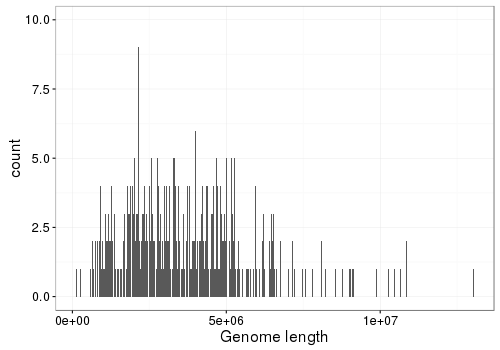

In [14]:
%%R -w 500 -h 350
# genome lengths
ggplot(tbl, aes(total_length)) +
    geom_histogram(binwidth=10000) +
    labs(x='Genome length') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

In [15]:
%%R
summary(tbl$total_length)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
  112100  2206000  3473000  3729000  4865000 13030000 


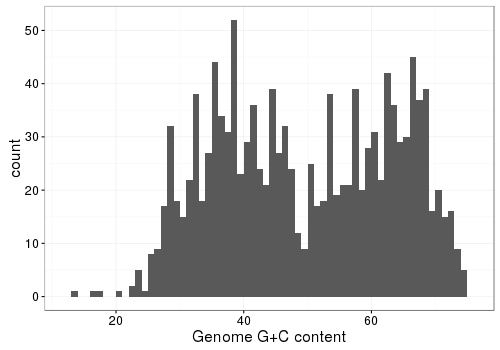

In [16]:
%%R -w 500 -h 350
# genome GC
ggplot(tbl, aes(total_GC)) +
    geom_histogram(binwidth=1) +
    labs(x='Genome G+C content') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

In [17]:
%%R
summary(tbl$total_GC)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  13.54   37.89   49.03   49.69   62.36   74.91 


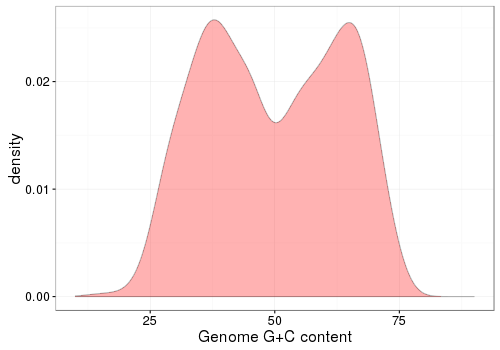

In [18]:
%%R -w 500 -h 350
# genome GC
ggplot(tbl, aes(total_GC)) +
    geom_density(fill='red', alpha=0.3) +
    scale_x_continuous(limits=c(10,90)) +
    labs(x='Genome G+C content') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

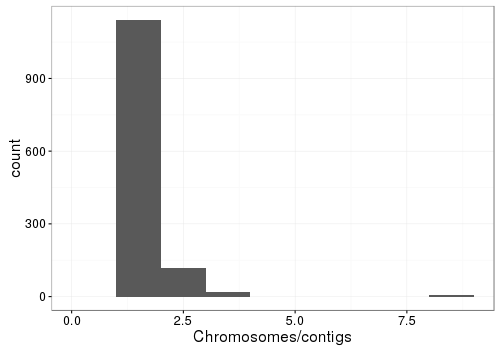

In [19]:
%%R -w 500 -h 350
# sequences per genome
ggplot(tbl, aes(total_seqs)) +
    geom_histogram(binwidth=1) +
    labs(x='Chromosomes/contigs') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

## Genomes with low G+C

In [27]:
%%R
tbl %>%
    filter(total_GC < 28) %>%
    arrange(total_GC) %>%
    mutate(taxon = gsub('.fasta', '', file_name)) %>%
    select(total_GC, taxon)

   total_GC                                                             taxon
1     13.54                            ./Candidatus_Zinderia_insecticola_CARI
2     16.56                                 ./Candidatus_Carsonella_ruddii_PV
3     17.13                ./Candidatus_Nasuia_deltocephalinicola_str_NAS-ALF
4     20.95                                 ./Candidatus_Sulcia_muelleri_PSPU
5     22.48 ./Wigglesworthia_glossinidia_endosymbiont_of_Glossina_brevipalpis
6     22.53                        ./Candidatus_Hepatoplasma_crinochetorum_Av
7     23.75                                         ./Mycoplasma_leachii_PG50
8     23.77               ./Mycoplasma_capricolum_subsp_capricolum_ATCC_27343
9     23.85             ./Blattabacterium_sp_Cryptocercus_punctulatus_str_Cpu
10    23.87                                     ./Spiroplasma_taiwanense_CT-1
11    23.95                              ./Mycoplasma_mycoides_subsp_mycoides
12    24.95                                          ./Mycoplasm

# Indexing genomes

* Needed for *in-silico* PCR

In [283]:
!cd $workDir; \
    $SIPSimExe indexGenomes genomes/genomes_all_list.txt \
    --fp ./genomes/ --np 30 > genomes/index_log.txt

Indexing: "Kangiella_koreensis_DSM_16069"
Indexing: "Polymorphum_gilvum_SL003B-26A1"
Indexing: "_Cellvibrio_gilvus_ATCC_13127"
Indexing: "Croceibacter_atlanticus_HTCC2559"
Indexing: "Sulfuricurvum_kujiense_DSM_16994"
Indexing: "Eubacterium_rectale_ATCC_33656"
Indexing: "Nocardia_nova_SH22a"
Indexing: "Gordonia_polyisoprenivorans_VH2"
Indexing: "Aeromonas_salmonicida_subsp_salmonicida_A449"
Indexing: "Thermodesulfobium_narugense_DSM_14796"
Indexing: "Brevibacillus_brevis_NBRC_100599"
Indexing: "Spiroplasma_culicicola_AES-1"
Indexing: "Isoptericola_variabilis_225"
Indexing: "Oscillibacter_valericigenes_Sjm18-20"
Indexing: "Desulfocapsa_sulfexigens_DSM_10523"
Indexing: "Planktomarina_temperata_RCA23"
Indexing: "Marinithermus_hydrothermalis_DSM_14884"
Indexing: "Shewanella_baltica_OS117"
Indexing: "Desulfosporosinus_orientis_DSM_765"
Indexing: "Halobacillus_halophilus_DSM_2266"
Indexing: "Cronobacter_sakazakii_SP291"
Indexing: "Chromohalobacter_salexigens_DSM_3043"
Indexing: "Sulfurimonas_